# Introduction

This project is a structured walk through of cleaning, prep, and analysis of a dataset sourced from Gapminder. The nature of the data is not typical business data, and isntead reflects my background as a social scientist, being historical information (population by country) matched against a socio-political index (GINI coeffcient, a measurement of inequality.) The insights drawn from it are therefore social scientific in nature and some of the methodology I use is particular to the social sciences--a fact which we'll discuss as we get into prepping the dataset for analysis.


During this we'll mainly address this research question:    

> Q: Is there a relationship between the increase or decline in a country's ranking and their gini coefficient?

During this exploration we'll primarily focus on two variables: a country's relative rank in population among all countries and their Gini coefficient. The first variable is easy to understand, but the latter might require some context if you are not familiar with common social science metrics. The Gini coefficient is a measurement of inequality in a country--how far the gap between rich and poor is, on average.

# Import - Initial Data Frame

Here we import the ddf-gapminder--system_globalis dataset and a series of tools to treat it. 
This dataset a large set of population trend data with an extremely wide range of dates and projections. 
We also set some formating options to make the presentation of that data better in a jupyter notebook like this.

Once imported the data is in long format, and we need to put it into wide format to carry out our analysis. It isn't necessary (though it is easier), but it's more readable with this category of data.

In [126]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy.stats import norm

# this code is meant only to improve readability, it autoformats floats to have zero significant digits in certain contexts.
pd.options.display.float_format = '{:,.0f}'.format


# This code imports and then pivots a subset of the auto-generated ddf-gapminder--system_globalis set.
df = pd.read_csv('ddf--datapoints--total_population_with_projections--by--geo--time.csv')
df = df.pivot_table(index='geo', columns='time', values='total_population_with_projections').reset_index()

# Import and Filter - Additional Dataframe

Our initial dataset gives us 252 countries with population data from 1086 to 2100, including projections past 2013 at 2050 and 2100.
But wait! There aren't 252 countries. So it looks like we have non-country information in this list. I want to just work with countries, so what do we do?
Simple, we just need to see where they intersect with the iso3 country codes list.

To do that we'll import a list of country iso codes and, after ensuring our dataframe's own iso3 codes are in the same case, do an intersect operation.

Commented our below is an example of doing this without using a vecotrized operation, which is far slower. 
It should be noted that whether or not to handle small n data with vectorized operations can often come down to readbility. While the loop is 29x slower, it can be more readonable in certain circumstances. In this case neither is superior, so we use the vectorized operation.

> The vectorized operation took 0.00045 seconds while the loop took 0.013 seconds. 29x faster.

Below we should see that our data is now much more restricted. Now, you may notice that it still has more entries than there are independent countries. Why is that? Well, it includes subnational entities, such as British Crown dependencies and Chinese special administrative regions. This is fine, as these regions are generally distinct from their parent polity.

In [127]:
# import and clean filter dataset

df_country_code = pd.read_csv('country_iso_codes.csv')

df['geo'] = df['geo'].str.upper()


# Commented example of using a loop for the filter.
'''
iso3_list = list(df_country_code['CountryCode'])

for index, row in df.iterrows():
    if row['geo'] not in iso3_list:
        df.drop(index, inplace=True)
'''


df = df[df['geo'].isin(df_country_code['CountryCode'])]


# This resets the index, something you often need to do when comparing filtered datasets with a common key.
df.reset_index(drop=True, inplace=True)

# we'll rename the column since it not excludes all but the country codes subset of the iso3 codes.
df.rename(columns={'geo': 'country_code'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Columns: 252 entries, country_code to 2100
dtypes: float64(251), object(1)
memory usage: 460.8+ KB


# Research Question

Now let's pose an actual research question.

Q: Is there a relationship between the increase or decline in a country's ranking and their gini coefficient?

Put another way, have countries that have experienced lower relative growth in population experienced more or less inequality?


For that let's add another dataset from gapminder and apply the same transformations we did earlier. Just as before we'll need to pivot it to wide format and do a little bit of formating to the column names and country codes as well as filter it with the country_code list.


In [128]:
# import and clean the second dataset
df_country_gini = pd.read_csv('ddf--datapoints--gapminder_gini--by--geo--time.csv')
df_country_gini = df_country_gini.pivot_table(index='geo', columns='time', values='gapminder_gini').reset_index()


df_country_gini['geo'] = df_country_gini['geo'].str.upper()
df_country_gini = df_country_gini[df_country_gini['geo'].isin(df_country_code['CountryCode'])]

df_country_gini.reset_index(drop=True, inplace=True)
df_country_gini.rename(columns={'geo': 'country_code'}, inplace=True)

# Filling in Data Gaps Note

During my initial submission of this project the reviewer pointed out that large amounts of artificial data were generated in the following section. While that would normally be a valid concern for, example, business data or continuous data that is unpredictable, population data has these traits:

1. It is predictable.
2. It is indirectly measurable through qualitative means
3. The primary source of it prior to the 1950's outside of the West is through these qualitative means.

So running a regression to fill in an estimate of population between, for example, the year 1800 and 1820 doesn't produce invalid data or reduce the validity of the results--at least not below the standard of the social sciences. The trendlines are predictable, with large shifts in population being a relative rarity in history and population growth or decline happening at a glacial rate that's fairly consistent on a scale measured in centuries.

Now why does this matter? There are lacunae in the estimates of population prior to the year 1900 for most countries, including in this gapminder dataset that we've used. Generally that's not an issue for the reasons I stated above--an historian or social scientist would simply draw a trend and use that number because in history there has almost never been an instance where populations shift up or down beyond the margin of error on a polity-scale measurement.


That all being said, what are we doing below?

# Interpolation of Historical Population Data By Year

Below we start by comparing out gini and our population dataframes, after copying them, and then intersecting them so we only have common country_codes.

We'll then check for any null values. As we can see, the gini information contains no null values while the population information contains many. However, if we do a check, we can see that the range of data that we have remaining, 1800-2013, has non-null values at both ends of the dataset. We know we have data in the lastest years for every country, so we only check for 1800, a year that stands out in demographic science for estimates of population.

This makes a regression possible with a good level of certainty. Good enough for the resolution of our analysis, at least, which is not necessarily looking at any single country to draw conclusions.

In an analysis where we were going to focus on a single country, we would probably want to pick an interval--such as 10 years--and try to find primary sources to corrobarate that there are no serious changes in the population that year such as migrations, wars, or famines. We would apply that analysis to any artificial data we generated. Then we would actually need to qualify these events' affect on the shape of the population curve. Having worked with demographic data extensively, it's uncommon for the effect to alter the trend. Eve

In [129]:
# first we'll do this so we don't destroy our original data
dfpop = df
dfgini = df_country_gini

# ensure that we restrict our years to a common set
common_columns = list(set(dfpop.columns) & set(dfgini.columns))
common_country_codes = list(set(dfpop['country_code']) & set(dfgini['country_code']))

# ensure that we restrict our country_codes to a common set
dfpop = dfpop[dfpop['country_code'].isin(common_country_codes)][common_columns]
dfgini = dfgini[dfgini['country_code'].isin(common_country_codes)][common_columns]

# reset the indexes
dfpop.reset_index(drop=True, inplace=True)
dfgini.reset_index(drop=True, inplace=True)

dfpop.info()
print()
dfgini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 215 entries, country_code to 2013
dtypes: float64(214), object(1)
memory usage: 326.0+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 215 entries, country_code to 2013
dtypes: float64(214), object(1)
memory usage: 326.0+ KB


In [130]:
# check for null values
popnull = dfpop.isnull().values.any()
gininull = dfgini.isnull().values.any()
print(f'Pop Nulls: {popnull}')
print(f'Gini Nulls: {gininull}')

# check for null values in 1800
nulls_1800 = dfpop[1800].isnull().any()
print(f'1800 Has Nulls: {nulls_1800}')

Pop Nulls: True
Gini Nulls: False
1800 Has Nulls: False


# Algorithm To Fill Null Population Values

This algorithm defines a function that can take a starting point and a stopping point within a row and a row itself. It then runs a linear regression to estimate the values between theose stopping points.

That function is called by a loop which iterates through each row and then column identifying extents within the data that are filled by null values. The extents can be of arbitrary length.

In [131]:
def nullFill(start, stop, row):
    # first we break up our input values, which we passed as a tuple.
    start_value, start_i = start
    end_value, end_i = stop
    # get our list of null years
    null_years = row.index[start_i:end_i]
    # now we run our regression, grabbing the x and y for the model from our starting values.
    x = np.array([start_i - 1, end_i + 1])
    y = np.array([start_value, end_value])
    coefficients = np.polyfit(x, y, deg=1)
    null_values = np.polyval(coefficients, np.arange(start_i, end_i))
    
    row[null_years] = null_values
    return row


# now let's go through out dataset finding null extents and fill ing them.
for index, row in dfpop.iterrows():
    for i, value in enumerate(row):
        # if the value is null but the previous value isn't, we've found a null extent.
        if pd.isnull(value) and not pd.isnull(row.values[i - 1]):
            nullExStart = (row.values[i - 1], i)
        # find the end of the null extent
        if not pd.isnull(value) and pd.isnull(row.values[i - 1]):
            nullExEnd = (row.values[i], i)
            # now that we have our end, we can handle the extent
            dfpop.loc[index] = nullFill(nullExStart, nullExEnd, row)

dfpop.head(10)


time,country_code,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,AFG,"3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000","3,280,000",...,"26,690,000","27,610,000","28,420,000","29,150,000","29,840,000","30,580,000","31,410,000","32,360,000","33,400,000","34,500,000"
1,AGO,"1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000","1,567,000",...,"15,960,000","16,490,000","17,010,000","17,530,000","18,040,000","18,560,000","19,080,000","19,620,000","20,160,000","20,710,000"
2,ALB,"410,400","411,667","412,933","414,200","415,467","416,733","418,000","419,267","420,533",...,"3,125,000","3,142,000","3,157,000","3,170,000","3,181,000","3,193,000","3,204,000","3,216,000","3,227,000","3,238,000"
3,AND,"2,654","2,654","2,654","2,654","2,654","2,654","2,654","2,654","2,654",...,"75,290","77,890","79,870","81,390","82,580","83,680","84,860","86,160","87,520","88,910"
4,ARE,"40,150","40,150","40,150","40,150","40,150","40,150","40,150","40,150","40,150",...,"3,658,000","4,069,000","4,663,000","5,406,000","6,207,000","6,939,000","7,512,000","7,891,000","8,106,000","8,208,000"
5,ARG,"534,000","534,000","534,000","534,000","534,000","534,000","534,000","534,000","534,000",...,"38,340,000","38,680,000","39,020,000","39,370,000","39,710,000","40,060,000","40,410,000","40,760,000","41,120,000","41,470,000"
6,ARM,"413,300","413,300","413,300","413,300","413,300","413,300","413,300","413,300","413,300",...,"3,063,000","3,066,000","3,070,000","3,074,000","3,079,000","3,085,000","3,092,000","3,100,000","3,109,000","3,118,000"
7,ATG,"37,000","37,000","37,000","37,000","37,000","37,000","37,000","37,000","37,000",...,"82,840","83,920","84,950","85,940","86,880","87,800","88,710","89,610","90,510","91,400"
8,AUS,"351,000","350,190","349,381","348,571","347,762","346,952","346,143","345,333","344,524",...,"20,100,000","20,400,000","20,740,000","21,120,000","21,510,000","21,900,000","22,270,000","22,610,000","22,920,000","23,210,000"
9,AUT,"3,206,000","3,213,762","3,221,524","3,229,286","3,237,048","3,244,810","3,252,571","3,260,333","3,268,095",...,"8,186,000","8,232,000","8,273,000","8,310,000","8,342,000","8,370,000","8,394,000","8,413,000","8,429,000","8,441,000"


# Posing questions

Now at this point we could do a number of things, like translating the iso3 codes into country names. Or cleaning this data. 
We could begin by asking some very basic questions:
    Q: What was the population in 1950 vs 2013?
    Q: What about the top 10 largest countries in those two years?
    
Those sorts of questions are relatively 1-dimensional, though, and don't make for very interesting research.

However, graphing and analyzing these more-simple numbers can tell us a bit about our dataset. For example, how do we compare against United Nations population estimates for a given year? We'll compare against publically available data in the United Nations, Department of Economic and Social Affairs, Population Division. World Population Prospects: The 2019 Revision.

Below we can see we got sums for our population like this:

Population 1950: 2,518,878,937
Population 2013: 7,089,955,598

The UN estimates are as follows:

Population 1951: 2,584,034,261
Population 2013: 7,210,581,976

So we're not totally on the same page, but we're close. We're about right with 1950, though the UN data doesn't supply that exact year. We're a little low on 2013.

The 2013 data probably just indicates these two things: First, we've got some not-up-to-date data for individual countries, which is common in this analysis. Census records aren't collected every year and estimates can be wrong. Second, the UN data is likely a projection based on end-of-year information while the gapminder data is a calculation of start of year information. This is another common difference in how demographic information is collected--granular information is compiled for January 1st while general information is compiled for December 31st.

Additionally, we did drop a number of countries that lacked Gini coefficient information, so we should expect our estimates to be lower.

Finally, just to test the validity of our projection, I compared our projection to the UN's projection for 1804, which is the year widely-cited as us hitting 1-billion people.

UN Projection: 
Population 1804: 1,000,000,000
Our projection:
Population 1804: 963,947,389

Given our prior constraints, that sounds just about right. So we can move on with our analysis with some degree of certainty that our data is fair on a global-scale.

In [132]:
# population comparison of 1950 and 2013
pop1950 = dfpop[1950].sum()
pop2013 = dfpop[2013].sum()
print(f'Population 1950: {pop1950:,.0f}')
print(f'Population 2013: {pop2013:,.0f}')

# top ten largest countries in 1950 and 2013
top10_1950 = dfpop.nlargest(10, 1950)[['country_code', 1950]]
top10_2013 = dfpop.nlargest(10, 2013)[['country_code', 2013]]

# Display the top 10 country codes
print(top10_1950.to_string(index=False))
print(top10_2013.to_string(index=False))

# and 1804 just to test the accuracy of our projection against un estimates
pop1804 = dfpop[1804].sum()
print(f'Population 1804: {pop1804:,.0f}')


Population 1950: 2,518,878,937
Population 2013: 7,089,955,598
country_code        1950
         CHN 550,800,000
         IND 371,900,000
         USA 157,800,000
         RUS 102,700,000
         JPN  82,200,000
         IDN  74,840,000
         DEU  68,380,000
         BRA  53,970,000
         GBR  50,620,000
         ITA  46,370,000
country_code          2013
         CHN 1,359,000,000
         IND 1,275,000,000
         USA   318,500,000
         IDN   247,200,000
         BRA   200,100,000
         PAK   183,200,000
         NGA   170,900,000
         BGD   154,400,000
         RUS   142,600,000
         JPN   126,300,000
Population 1804: 963,947,389


# Testing Setup

Now we have what should be two nice and complete little datasets with reasonably interpolated synthetic datapoints in place of the null values.

Now we can see if there's any correlation between inequality and a country's calculated rank in a given year.
The below cell will prompt you for valid input numbers within the range of our dataset. It's designed to work with a dataset of any size so long as it's mapped the same.

The cell after that will then grab the start and end ranks for the countries, calculating how many ranks they have changed. We haven't set this up to display country_code because we aren't interested in the performance of individual countries, but doing so would be relatively easy, mapping the index to the source dataframes.

In [133]:
# hint: enter numbers between 1800 and 2013
while True:
    start_year = int(input("Enter the start year: "))
    end_year = int(input("Enter the end year: "))
    if start_year < end_year and start_year >= dfpop.columns[1] and end_year <= dfpop.columns[-1]:
        break

Enter the start year:  1800
Enter the end year:  2013


In [207]:
# this gives us countries ranked by population
start_rank = dfpop[start_year].rank(ascending=False, method='min')
print(f'Starting ranks by index: \n{start_rank}\n')

# This grabs us the change in a country's rank in population.
change_in_rank = start_rank - dfpop[end_year].rank(ascending=False, method='min')
print(f'Change in rank by index: \n{change_in_rank}\n')

# this grabs the mean gini coefficient for the time period entered
gini_columns = list(range(start_year, end_year))
gini_coefficients = dfgini[gini_columns].mean(axis=1)

Starting ranks by index: 
0      34
1      62
2     114
3     191
4     168
       ..
189   166
190    40
191    64
192    94
193    75
Name: 1800, Length: 194, dtype: float64

Change in rank by index: 
0      -5
1       4
2     -19
3       7
4      74
       ..
189    -9
190    -7
191    40
192    25
193     4
Length: 194, dtype: float64



# Posing questions 2

Now that we have generated some additional data, let's inspect it to see if there is anything surprising here. We would expect a normal distribution to this data, but a measure like change in rank here could be peculiar. Perhaps we have some countries climbing dozens of ranks while most only drop a few.

Below we generated such a distribution and we can see it's mostly normal, with a bias toward the left-tail. In this case it's not clear which way the data biases, but the nature of the data means we could draw some conclusions from it. For example, it seems countries were more likely to decline by a lot than to get by a lot, showing that countries that experience a lot of gain on-average started lower in their rankings and were fewer in number while countries that experienced a lot of loss on-average started higher and were more numerous.

A slightly more interesting figure is the proportion between their 1800 and 2013 popualtions. As you can see below this data is absolutely **not** normally distributed. We would expect an average increase in population to be something like 7 times. However, the vast majority of countries increased by more than that. Some **massively** so, with differences of more than 200x in population (great job, UAE).



<Axes: >

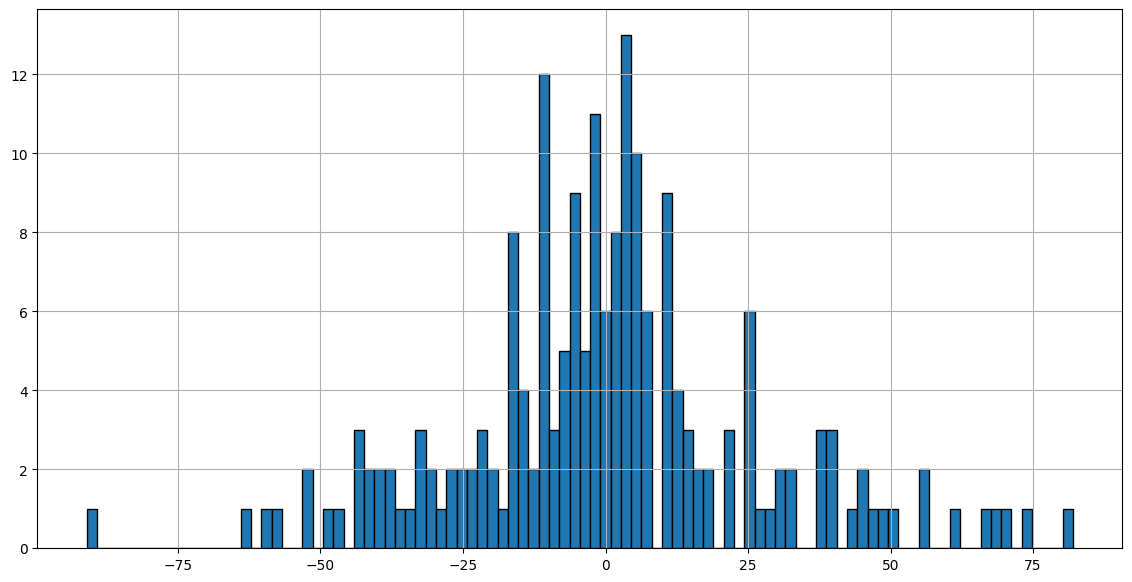

In [208]:
# a histogram showing the distribution of our change-in-rank data
change_in_rank.hist(grid=True, bins=96, edgecolor='black', figsize=[14, 7])

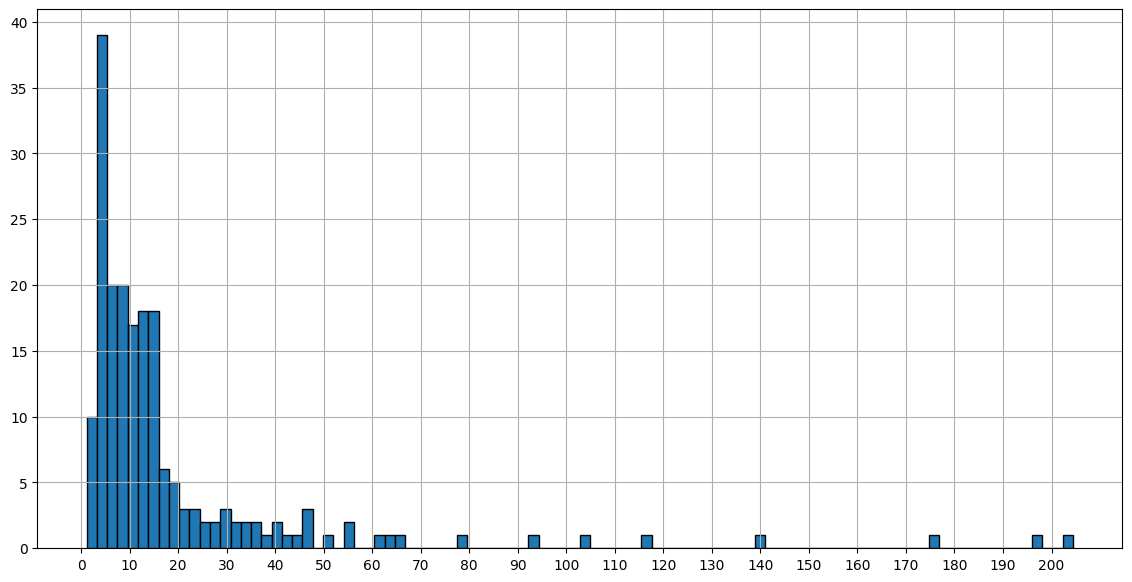

In [209]:
# calculate percentage difference in population

population_change_proportion = (dfpop[end_year] / dfpop[start_year])
# a histogram showing the distribution of our population percent difference data
population_change_proportion.hist(grid=True, bins=96, edgecolor='black', figsize=[14, 7])
# just some formating so we can read the data better
tick_interval = [i for i in range(0, 205, 10)]
plt.xticks(tick_interval)
plt.show()

In [210]:
print(population_change_proportion)

0      11
1      13
2       8
3      34
4     204
       ..
189     4
190    10
191    35
192    19
193    12
Length: 194, dtype: float64


# Correlation Testing

Below we'll generate some correlation coefficients, which we'll interpret in our conclusion. These use the numpy function corrcoef, which takes two values and compares them at each index, generating a score between -1 and 1 for how they are correlated. This function is a Pearson analysis by default. Non-0 values indicate a relationship.

Will also print the Fisher z-score and related stats of our main research question correlation score, which is listed below as:
> Correlation between change in rank and Gini coefficient

Then generate a z-test and then a p-value from that to see if our results are significant.

Additionally we will test two other correlations, the relationship between starting rank and change in rank, and the relationship between starting rank and mean Gini coefficient over the time period.

In [211]:
# here we calculate and print our correlation coefficients
correlation_start_rank_change = np.corrcoef(start_rank, change_in_rank)[0, 1]
correlation_start_rank_gini = np.corrcoef(start_rank, gini_coefficients)[0, 1]
correlation_change_in_rank_gini = np.corrcoef(change_in_rank, gini_coefficients)[0, 1]

print("Correlation between starting rank and change in rank:", correlation_start_rank_change)
print("Correlation between starting rank and Mean Gini coefficient:", correlation_start_rank_gini)
print("Correlation between change in rank and Gini coefficient:", correlation_change_in_rank_gini)

Correlation between starting rank and change in rank: 0.23758802477608323
Correlation between starting rank and Mean Gini coefficient: 0.16377049446028172
Correlation between change in rank and Gini coefficient: 0.3697287095169644


In [212]:
# here we create a summary for our main research question, which is the 
r = correlation_change_in_rank_gini
# grabs the sample size, minus the header
N = dfpop.shape[0] - 1

# Fisher z-score calculation
z = 0.5 * np.log((1 + r) / (1 - r))

# standard error
std_err = 1 / np.sqrt(N - 3)

# z-test calculation
zt = z / std_err

# p-value, finally
p = 2 * (1- norm.cdf(np.abs(zt)))

print(f'P-value: {p}')


P-value: 8.809487939132055e-08


# Correlation Testing Graphs

In addition to our regular correlations we can demonstrate the three relationships we tested above with basic graphs, which sets us up for further explorations.

As you can see below, we have trends in the data in all three--there's a slope to the line all every graph. However, our main hypothesis in graph 3 (Gini Coefficient vs Change in Rank) stands out as a *very* strong correlation if we use the years 1800-2013.

From looking at these graphs we can see our relationships pretty clearly and there are some interesting things we can draw from the distribution of each.

* Graph 1: As your starting rank goes down, your potential for losing goes down as well, and your potential for gaining rank goes up. The makes sense, of course--you can only go up from 194 and only go down from 1. Likewise for the inverse--higher starting ranks have higher potential for losing rank and lower for gaining. Another obversation here is that the data is fairly evenly distributed, with countries across all ranks likely to change in rank in our test period, though countries that started lower are at least a little bit more likely to have climbed than higher countries are to have fallen.

* Graph 2: While there is some correlation visible in this graph, it does reveal that there isn't a strong relationship between a country's size in 1800 and its mean gini coefficient between then and 2013, though smaller countries then tended toward more inequality, but not by much. 

* Graph 3: This graph demostrates really strong clustering around the center of the dataset but nonetheless demonstrates a very strong relationship between our core test variables. Mean gini coefficient obviously connects with the change in a country's rank over this time period.

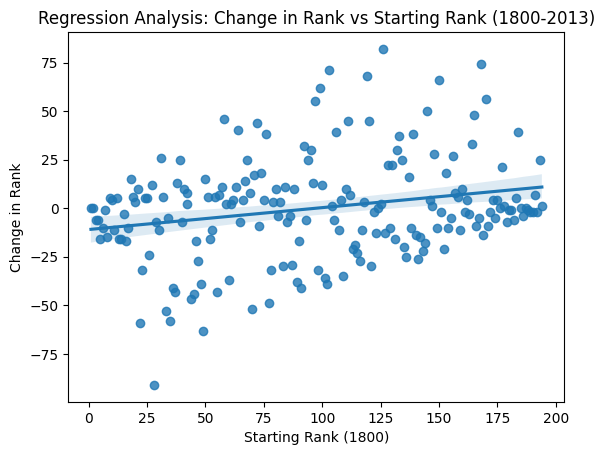

In [213]:
# Now, we could move on to other angles of analysis from here to understand these relationships. For example:
# Making a regression showing the relationship between start and end rank.
sbn.regplot(x=start_rank, y=change_in_rank)
plt.xlabel(f'Starting Rank ({start_year})')
plt.ylabel("Change in Rank")
plt.title(f'Regression Analysis: Change in Rank vs Starting Rank ({start_year}-{end_year})')
plt.show()

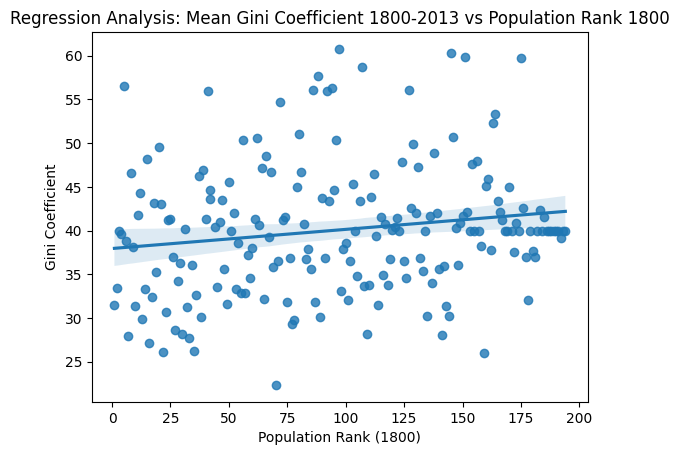

In [214]:
# or start rank and gini
sbn.regplot(x=start_rank, y=gini_coefficients)

plt.xlabel(f'Population Rank ({start_year})')
plt.ylabel("Gini Coefficient")
plt.title(f'Regression Analysis: Mean Gini Coefficient {start_year}-{end_year} vs Population Rank {start_year}')
plt.show()

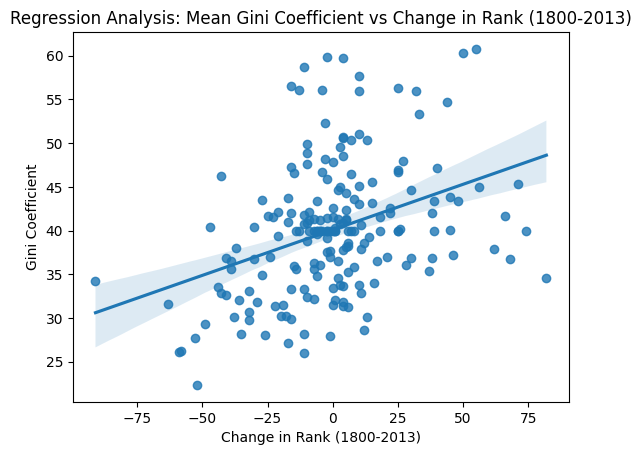

In [215]:
# or change in rank vs gini
sbn.regplot(x=change_in_rank, y=gini_coefficients)

plt.xlabel(f'Change in Rank ({start_year}-{end_year})')
plt.ylabel("Gini Coefficient")
plt.title(f'Regression Analysis: Mean Gini Coefficient vs Change in Rank ({start_year}-{end_year})')
plt.show()

# Results

Alright we have some results!

On our test question using the years 1800 and 1950:

    Q: Is there a relationship between the increase or decline in a country's ranking and their gini coefficient?

We generated a vanishingly small P-value of:

    0.00000008809487939132055

I didn't set a singificance threshold in this analysis, though even if I had set a strict one it would not have changed out results.

But let's look at and interpret our actual results, rather than just our significance test.

Remember that negative numbers indicate a negative relationship, 0 no relationship, and positive a positive relationship.    
* Positive: as A increases, B increases
* Zero: no relationship
* Negative: as A increases, B decreases

Let's go over them, then.
* Correlation between starting rank and change in rank: -0.23758802477608323

This indicates that higher starting ranks correlated with bigger drops in rank and vice versa.
* Correlation between starting rank and Mean Gini coefficient: 0.16377049446028172

This indicated that bigger countries in 1800 tended to have more inequality going forward.
* Correlation between change in rank and Gini coefficient: -0.3697287095169644

This indicated that countries with higher positive changes in rank experienced lower inequality.
    
# Discussion:
There are likely a lot of reasons why our results look the way they do. First off, inequality is not a perfect measurement of economic success. Poor countries tend to have low inequality where rich countries tend to have a much higher level of it (USA.) However, the poor in rich countries are typically better off than even the rich in poor countries. Additionally, a stagnant economy can reduce inequality while worsening life for every *and* both predict or result from a stalled population (Japan.) Likewise, some countries with extremely high inequality are so largely because they lack a middle class, not because their poor are especially poor or their rich are especially rich (South Africa.) These reasons and more are why I restricted my analysis to a broad metric of polity success--population increase.

What we did reveal is that in terms of population success, more inequality seems to be a good thing. Countries that experienced relative increases in population compared to the rest of the world had higher growth compared to those with lower. We won't go into any of the implications of this relationship here, however--this is a data science project, not a journal paper.
        
Further efforts:
    
    At this point the next research step would be to run many correlations and perform an analysis of statistical
        power in r-studio or something else.
    More graphs could also be produced, but the nature of my research question here is not condusive to those being useful.
        From here the natural steps would be to break the data down by region (easily done given I used iso3 codes) and do
        separate analyses of regions, cultures, etc. Adding additional data onto these sets is very easily done.
        
